In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem-ft_ELMo
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem_ELMo
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results_HAREM_mestrado_ciclo_0/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

320
320


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo', '3', '0']
['harem-ft', 'ELMo', '4', '0']
['harem-ft', 'ELMo', '5', '0']
['harem-ft', 'ELMo', '6', '0']
['harem-ft', 'ELMo', '7', '0']
['harem-ft', 'ELMo', '8', '0']
['harem-ft', 'ELMo', '9', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN', '1', '0']
['harem-ft', 'ELMo+CNN', '2', '0']
['harem-ft', 'ELMo+CNN', '3', '0']
['harem-ft', 'ELMo+CNN', '4', '0']
['harem-ft', 'ELMo+CNN', '5', '0']
['harem-ft', 'ELMo+CNN', '6', '0']
['harem-ft', 'ELMo+CNN', '7', '0']
['harem-ft', 'ELMo+CNN', '8', '0']
['harem-ft', 'ELMo+CNN', '9', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '3', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '4', '0']
['harem-ft

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 9]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,11,20,00:46:22,2782.0,139.10,0.998377,0.998466,0.981112,0.980583,0.980847,3.849414,0.980111,0.982188,0.823232,0.831633,0.827411,62.998245,0.978612,0.980188,0.829522,0.799332,0.814147,77.248705
1,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,12,20,00:22:47,1367.0,68.35,0.997897,0.998055,0.978373,0.973635,0.975998,3.954796,0.989643,0.990540,0.879177,0.892950,0.886010,35.350330,0.978402,0.980203,0.823936,0.795326,0.809378,83.973366
2,harem-ft_ELMo_2_0,harem-ft,ELMo,No,No,2,0,13,20,00:19:09,1149.0,57.45,0.998137,0.998262,0.977649,0.976302,0.976975,3.855790,0.984376,0.985047,0.847082,0.893843,0.869835,59.390949,0.978462,0.980068,0.829060,0.809683,0.819257,83.609045
3,harem-ft_ELMo_3_0,harem-ft,ELMo,No,No,3,0,14,20,00:23:53,1433.0,71.65,0.997940,0.998052,0.975603,0.974546,0.975075,4.645464,0.982919,0.984265,0.823529,0.859951,0.841346,54.943508,0.979092,0.980653,0.826309,0.811686,0.818932,83.605297
4,harem-ft_ELMo_4_0,harem-ft,ELMo,No,No,4,0,19,20,00:23:58,1438.0,71.90,0.997613,0.997816,0.974673,0.971762,0.973215,4.479836,0.984349,0.985636,0.870416,0.853717,0.861985,62.107901,0.977951,0.979602,0.814072,0.799666,0.806805,100.175203
5,harem-ft_ELMo_5_0,harem-ft,ELMo,No,No,5,0,13,20,00:22:26,1346.0,67.30,0.998262,0.998432,0.981749,0.978019,0.979880,3.963059,0.983152,0.984370,0.845433,0.869880,0.857482,61.076297,0.978131,0.979902,0.823108,0.806344,0.814640,82.894618
6,harem-ft_ELMo_6_0,harem-ft,ELMo,No,No,6,0,13,20,00:30:54,1854.0,92.70,0.997784,0.997988,0.976106,0.973727,0.974915,4.538179,0.988124,0.988723,0.867299,0.897059,0.881928,43.815717,0.978927,0.980443,0.827135,0.802003,0.814375,79.324988
7,harem-ft_ELMo_7_0,harem-ft,ELMo,No,No,7,0,19,20,00:20:06,1206.0,60.30,0.997951,0.998109,0.977291,0.976499,0.976895,4.271386,0.987645,0.988891,0.875306,0.899497,0.887237,45.661455,0.979227,0.980803,0.827704,0.810017,0.818765,93.037428
8,harem-ft_ELMo_8_0,harem-ft,ELMo,No,No,8,0,10,20,00:19:01,1141.0,57.05,0.997901,0.998014,0.973442,0.972914,0.973178,4.509830,0.983666,0.985374,0.879012,0.872549,0.875769,53.834974,0.978822,0.980473,0.834153,0.792654,0.812875,74.880097
9,harem-ft_ELMo_9_0,harem-ft,ELMo,No,No,9,0,19,20,00:21:14,1274.0,63.70,0.998266,0.998391,0.980233,0.978643,0.979437,3.700818,0.982782,0.984543,0.845036,0.870324,0.857494,76.218397,0.978386,0.980068,0.827728,0.805342,0.816382,98.301604


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:24:31.153125'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,160.0,81.313559,0.566419,78.960688,0.810186,0.813993,0.816634,82.352941
Não,160.0,81.161873,0.571999,79.414298,0.807635,0.811970,0.815199,82.576917


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo,20.0,81.403299,0.358037,80.680478,0.812301,0.814099,0.816262,81.925676
ELMo+CNN+Vetor,140.0,81.250063,0.559631,79.558011,0.809199,0.812675,0.816591,82.576917
ELMo+Vetor,140.0,81.218601,0.575361,79.451127,0.808575,0.813007,0.815855,82.436070
ELMo+CNN,20.0,81.119513,0.794432,78.960688,0.807932,0.812659,0.815983,82.218102


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Sem Vetor,80.0,81.357933,0.605116,78.960688,0.811088,0.814526,0.817330,82.352941
Skip-Gram,120.0,81.302360,0.511341,79.878869,0.809848,0.812909,0.816631,82.436070
CBoW,120.0,81.092928,0.584531,79.451127,0.807855,0.811594,0.814974,82.576917


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,40.0,81.454460,0.576225,80.154466,0.813216,0.816272,0.817834,82.352941
Wang2Vec,80.0,81.443397,0.534443,80.106189,0.811381,0.814644,0.818619,82.576917
Sem Vetor,40.0,81.261406,0.624957,78.960688,0.810572,0.813918,0.816160,82.218102
Word2Vec,80.0,81.080118,0.537857,79.836929,0.806849,0.811445,0.814410,82.192249
FastText,80.0,81.069416,0.524532,79.451127,0.808400,0.811386,0.814145,82.055660


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Sim         ELMo+Vetor     GloVe     Sem Vetor          10.0  81.645493   
Não         ELMo+Vetor     Wang2Vec  Skip-Gram          10.0  81.625488   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram          10.0  81.621075   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          10.0  81.556043   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram          10.0  81.519733   
                           GloVe     Sem Vetor          10.0  81.492588   
                           Wang2Vec  CBoW               10.0  81.492531   
            ELMo           Sem Vetor Sem Vetor          10.0  81.455554   
            ELMo+Vetor     Wang2Vec  CBoW               10.0  81.441570   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor          10.0  81.368891   
Sim         ELMo+CNN+Vetor FastText  CBoW               10.0  81.357148   
Não         ELMo           Sem Vetor Sem Vetor          10.0  81.351044   
            ELMo+Vetor     GloVe     Sem Vetor          10.0  81.310868   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram          10.0  81.282305   
            ELMo+CNN+Vetor FastText  Skip-Gram          10.0  81.275218   
Não         ELMo+CNN+Vetor Word2Vec  CBoW               10.0  81.196679   
Sim         ELMo+CNN       Sem Vetor Sem Vetor          10.0  81.191951   
Não         ELMo+Vetor     Wang2Vec  CBoW               10.0  81.181451   
                           Word2Vec  Skip-Gram          10.0  81.154145   
Sim         ELMo+CNN+Vetor Word2Vec  Skip-Gram          10.0  81.144789   
Não         ELMo+CNN+Vetor FastText  Skip-Gram          10.0  81.143639   
Sim         ELMo+Vetor     FastText  Skip-Gram          10.0  81.141313   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW               10.0  81.109287   
                           Word2Vec  Skip-Gram          10.0  81.084236   
            ELMo+Vetor     FastText  Skip-Gram          10.0  81.080337   
Sim         ELMo+CNN+Vetor Word2Vec  CBoW               10.0  81.047592   
Não         ELMo+CNN       Sem Vetor Sem Vetor          10.0  81.047075   
Sim         ELMo+Vetor     Word2Vec  CBoW               10.0  80.969806   
                           FastText  CBoW               10.0  80.938280   
Não         ELMo+Vetor     FastText  CBoW               10.0  80.906890   
                           Word2Vec  CBoW               10.0  80.761395   
            ELMo+CNN+Vetor FastText  CBoW               10.0  80.712503   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Sim         ELMo+Vetor     GloVe     Sem Vetor           0.590283  80.154466   
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           0.518159  80.711768   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           0.426514  81.039755   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.524228  80.744310   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.475043  80.767272   
                           GloVe     Sem Vetor           0.617935  80.262273   
                           Wang2Vec  CBoW                0.700410  80.232161   
            ELMo           Sem Vetor Sem Vetor           0.411258  80.680478   
            ELMo+Vetor     Wang2Vec  CBoW                0.456661  80.395163   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor           0.535612  80.208860   
Sim         ELMo+CNN+Vetor FastText  CBoW                0.452919  80.343898   
Não         ELMo           Sem Vetor Sem Vetor           0.308906  80.842322   
            ELMo+Vetor     GloVe     Sem Vetor           0.590297  80.325960   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram           0.545198  80.502092   
            ELMo+CNN+Vetor FastText  Skip-Gram           0.452454  80.291717   
Não         ELMo+CNN+Vetor Word2Vec  CBoW                0.505878  80.443548   
Sim         ELMo+CNN       Sem Vetor Sem Vetor           0.84

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,40.0,0.815806,0.004706,0.807118,0.811997,0.816067,0.819675,0.824361
glove,No,40.0,0.814545,0.005762,0.801545,0.813216,0.816272,0.817834,0.823529
wang2vec,cbow,40.0,0.813062,0.005644,0.801062,0.809105,0.813472,0.816489,0.825769
No,No,40.0,0.812614,0.006250,0.789607,0.810572,0.813918,0.816160,0.822181
word2vec,skip,40.0,0.811664,0.005096,0.801842,0.807748,0.812076,0.814605,0.821922
fasttext,skip,40.0,0.811601,0.004444,0.798789,0.808487,0.812046,0.814212,0.820557
word2vec,cbow,40.0,0.809939,0.005577,0.798369,0.806773,0.810729,0.814410,0.818628
fasttext,cbow,40.0,0.809787,0.005856,0.794511,0.807952,0.809793,0.813850,0.818487


In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,40.0,0.815806,0.004706,0.807118,0.811997,0.816067,0.819675,0.824361
glove,40.0,0.814545,0.005762,0.801545,0.813216,0.816272,0.817834,0.823529
No,40.0,0.812614,0.006250,0.789607,0.810572,0.813918,0.816160,0.822181
word2vec,40.0,0.811664,0.005096,0.801842,0.807748,0.812076,0.814605,0.821922
fasttext,40.0,0.811601,0.004444,0.798789,0.808487,0.812046,0.814212,0.820557


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,40.0,0.814545,0.005762,0.801545,0.813216,0.816272,0.817834,0.823529
wang2vec,40.0,0.813062,0.005644,0.801062,0.809105,0.813472,0.816489,0.825769
No,40.0,0.812614,0.006250,0.789607,0.810572,0.813918,0.816160,0.822181
word2vec,40.0,0.809939,0.005577,0.798369,0.806773,0.810729,0.814410,0.818628
fasttext,40.0,0.809787,0.005856,0.794511,0.807952,0.809793,0.813850,0.818487


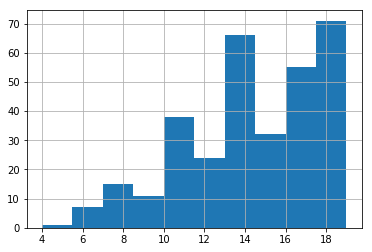

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count     320.000000
mean     1471.153125
std       328.086814
min      1141.000000
25%      1253.750000
50%      1424.000000
75%      1520.250000
max      2969.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,32.0,0.814294,0.006043,0.795580,0.811919,0.814485,0.817744,0.825769
3,32.0,0.814209,0.004650,0.804090,0.810868,0.815252,0.817438,0.821922
8,32.0,0.813406,0.004566,0.805654,0.810216,0.812672,0.817154,0.822917
2,32.0,0.813305,0.004511,0.798772,0.812415,0.814132,0.816253,0.820784
1,32.0,0.812821,0.004578,0.802089,0.809233,0.813831,0.816024,0.822298
6,32.0,0.812524,0.004677,0.801632,0.808429,0.813124,0.815954,0.822218
7,32.0,0.811906,0.006291,0.799868,0.807635,0.811858,0.817326,0.823529
0,32.0,0.811657,0.006060,0.794143,0.808350,0.812452,0.814475,0.824361
4,32.0,0.810858,0.006823,0.794511,0.806496,0.812518,0.816278,0.822815


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,320.0,0.812377,0.005734,0.000321,0.811747,0.813008


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,40,0.812614,0.006250,0.000988,0.810677,0.814551
fasttext,80,0.810694,0.005245,0.000586,0.809545,0.811844
glove,40,0.814545,0.005762,0.000911,0.812759,0.816330
wang2vec,80,0.814434,0.005344,0.000598,0.813263,0.815605
word2vec,80,0.810801,0.005379,0.000601,0.809623,0.811980


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 315) =  7.879, p =  0.00000459829213497003
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7.879
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           4.60e-06
Time:                        09:19:30   Log-Likelihood:                 1213.3
No. Observations:                 320   AIC:                            -2417.
Df Residuals:                     315   BIC:                            -2398.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [28]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
113,harem-ft_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,11,20,00:29:56,1796.0,89.80,0.998433,0.998612,0.983771,0.980852,0.982309,2.933687,0.980221,0.982297,0.826733,0.852041,0.839196,64.771994,0.978206,0.979932,0.827909,0.798331,0.812851,80.755276
114,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,15,20,00:23:12,1392.0,69.60,0.998654,0.998722,0.983338,0.984396,0.983867,2.830908,0.988349,0.989345,0.882653,0.903394,0.892903,44.590681,0.979002,0.980758,0.823946,0.815693,0.819799,89.367576
115,harem-ft_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft,ELMo+Embeddings,wang2vec,skip,2,0,17,20,00:19:31,1171.0,58.55,0.998467,0.998569,0.981236,0.979884,0.980560,3.197974,0.984856,0.985910,0.855397,0.891720,0.873181,66.529154,0.978432,0.980203,0.837913,0.804341,0.820784,103.374336
116,harem-ft_ELMo+Embeddings_wang2vec_skip_3_0,harem-ft,ELMo+Embeddings,wang2vec,skip,3,0,10,20,00:23:26,1406.0,70.30,0.998638,0.998761,0.984783,0.981316,0.983046,2.675114,0.982609,0.983747,0.834123,0.864865,0.849216,57.177565,0.979107,0.980623,0.826625,0.802337,0.814300,77.436336
117,harem-ft_ELMo+Embeddings_wang2vec_skip_4_0,harem-ft,ELMo+Embeddings,wang2vec,skip,4,0,13,20,00:23:48,1428.0,71.40,0.998540,0.998642,0.983184,0.984252,0.983718,3.310123,0.984151,0.985042,0.870416,0.853717,0.861985,55.164751,0.978882,0.980353,0.825322,0.814023,0.819634,83.847991
118,harem-ft_ELMo+Embeddings_wang2vec_skip_5_0,harem-ft,ELMo+Embeddings,wang2vec,skip,5,0,18,20,00:22:33,1353.0,67.65,0.998793,0.998838,0.984807,0.985075,0.984941,2.737665,0.984370,0.985588,0.853774,0.872289,0.862932,69.016578,0.979272,0.980983,0.829024,0.803005,0.815807,103.212363
119,harem-ft_ELMo+Embeddings_wang2vec_skip_6_0,harem-ft,ELMo+Embeddings,wang2vec,skip,6,0,19,20,00:29:57,1797.0,89.85,0.998462,0.998553,0.981306,0.981040,0.981173,2.895771,0.988423,0.989321,0.879808,0.897059,0.888350,49.870601,0.978777,0.980443,0.825506,0.804007,0.814614,100.993161
120,harem-ft_ELMo+Embeddings_wang2vec_skip_7_0,harem-ft,ELMo+Embeddings,wang2vec,skip,7,0,16,20,00:23:04,1384.0,69.20,0.998841,0.998942,0.984337,0.984603,0.984470,2.475870,0.988268,0.989618,0.889724,0.891960,0.890841,47.286311,0.977801,0.979647,0.824974,0.796327,0.810398,98.049989
121,harem-ft_ELMo+Embeddings_wang2vec_skip_8_0,harem-ft,ELMo+Embeddings,wang2vec,skip,8,0,17,20,00:19:10,1150.0,57.50,0.998777,0.998867,0.984286,0.984020,0.984153,2.886291,0.985908,0.987403,0.894737,0.875000,0.884758,68.207191,0.977426,0.979197,0.822077,0.800668,0.811231,111.091367
122,harem-ft_ELMo+Embeddings_wang2vec_skip_9_0,harem-ft,ELMo+Embeddings,wang2vec,skip,9,0,19,20,00:19:37,1177.0,58.85,0.998856,0.998935,0.986220,0.986753,0.986486,2.849660,0.981021,0.983369,0.836930,0.870324,0.853301,89.609018,0.979767,0.981523,0.837193,0.808681,0.822690,101.869969
